# コンスタレーション

In [1]:
#import
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. ANN定義

In [2]:
def data_shaping(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, 0::2] = signal[j - tap // 2: j + tap // 2 + 1].real
        x[i, 1::2] = signal[j - tap // 2: j + tap // 2 + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y


class Dataset(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)


class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def evm_score(y_pred, y_true):
    tmp = 0
    for i in range(len(y_pred)):
        tmp += ((y_pred[i][0] - y_true[i][0]) ** 2 + (y_pred[i][1] - y_true[i][1]) ** 2) / (y_true[i][0] ** 2 + y_true[i][1] ** 2)
    if type(tmp) is np.float64:
        evm = np.sqrt(tmp / len(y_pred))
    else:
        evm = torch.sqrt(tmp / len(y_pred))
    return evm

# 2. 可視化

### データ読み込み

In [3]:
def prepare_input(signal_info, form, PdBm, Lmax):
    max_tap = 501
    
    # t_condition 伝送条件
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか
    signal_type = signal_info['signal_type']
    if signal_type == 'prbs':
        N = signal_info['N']  # PRBSの次数
        itr = signal_info['itr']  # PRBSの繰り返し回数
    elif signal_type == 'random':
        seed = signal_info['seed']  # 乱数シード
        bit_num = signal_info['bit_num']  # ビット長を指定
    elif signal_type == 'image':
        target_dir = signal_info['target_dir']
        step = signal_info['step']  # =10 ---> (768, 1024) ---> (76, 102)
        image_number = signal_info['image_number']
        ebtb = signal_info['ebtb']  # 8B10Bを行うか

    # prbs.csv or random.csv or image.csvの列指定に用いる文字列
    t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                            gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    if signal_type == 'prbs':
        condition = 'N=='+str(N)+'&itr=='+str(itr)
    elif signal_type == 'random':
        condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    elif signal_type == 'image':
        condition = 'target_dir=="'+target_dir+'"&step=='+str(step)+'&image_number=='+image_number+'&ebtb=='+str(ebtb)

    # prbs.csv or random.csv or image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir+signal_type+'.csv', index_col=0)

    # prbs.csv or random.csv or image.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(condition + '&' + t_condition)

    # 伝送信号を入力データに整形する
    sgnl = load_pickle(t_query.iloc[0]['data_path'])
    lc = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
    x, y = data_shaping(sgnl.signal['x_0'][n//2::n], lc[n//2::n], max_tap, tap)
    return x, y

### Model読み込み

In [4]:
def prepare_model(tap, batch_size, neuron, epochs, lr, signal_info, form, PdBm, Lmax):
    device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
    # print('Device available now:', device)

    # l_condition 学習条件
    max_tap = 501

    # t_condition 伝送条件
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか
    signal_type = signal_info['signal_type']
    if signal_type == 'prbs':
        N = signal_info['N']  # PRBSの次数
        itr = signal_info['itr']  # PRBSの繰り返し回数
        x, y = prepare_input(signal_info=signal_info, form=form, PdBm=PdBm, Lmax=Lmax)
    elif signal_type == 'random':
        seed = signal_info['seed']  # 乱数シード
        bit_num = signal_info['bit_num']  # ビット長を指定
        x, y = prepare_input(signal_info=signal_info, form=form, PdBm=PdBm, Lmax=Lmax)
    elif signal_type == 'image':
        target_dir = signal_info['target_dir']
        step = signal_info['step']  # =10 ---> (768, 1024) ---> (76, 102)
        image_number = signal_info['image_number']
        ebtb = signal_info['ebtb']  # 8B10Bを行うか
        x, y = prepare_input(signal_info=signal_info, form=form, PdBm=PdBm, Lmax=Lmax)

    # ANN.csvの列指定に用いる文字列
    l_condition = 'tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&learning_rate=='+str(lr)
    t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                            gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    if signal_type == 'prbs':
        condition = 'N=='+str(N)+'&itr=='+str(itr)
    elif signal_type == 'random':
        condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    elif signal_type == 'image':
        condition = 'target_dir=="'+target_dir+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)

    # ANN.csvをpandasで読み込む
    l_df_dir = '../data/params/ANN.csv'
    l_df = pd.read_csv(l_df_dir, index_col=0)

    # ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
    l_query = l_df.query(l_condition + '&' + condition + '&' + t_condition + '&Lmax=='+str(Lmax))

    if len(l_query) == 0 or l_query['epochs'].max() < epochs:
        print('指定された条件の学習結果は存在しません')
    else:
        index = l_query[l_query['epochs']==epochs].index
        model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron).to(device)
        model.load_state_dict(torch.load(l_query['params_path'][index].values[0]))

    mean = np.mean(x)
    std = np.std(x)
    return model, mean, std

### 予測

In [5]:
def predict(tap, batch_size, neuron, epochs, lr, signal_info_model, signal_info_input, form, PdBm, Lmax):
    model, mean, std = prepare_model(tap=tap, batch_size=batch_size, neuron=neuron, epochs=epochs, lr=lr, signal_info=signal_info_model, form=form, PdBm=PdBm, Lmax=Lmax)
    
    x, y = prepare_input(signal_info=signal_info_input, form=form, PdBm=PdBm, Lmax=Lmax)
    dataset = Dataset(x=x, y=y, mean=mean, std=std)
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    annc = model(dataset[:][0]).detach().numpy()
    annc = annc * std + mean
    evm = round(evm_score(annc, y) * 100, 2)
    return evm

## 2.1 コンスタレーション

In [6]:
def display_constellation(tap, batch_size, neuron, epochs, lr, signal_info_model, signal_info_input, form, PdBm, Lmax):
    model, mean, std = prepare_model(tap=tap, batch_size=batch_size, neuron=neuron, epochs=epochs, lr=lr, signal_info=signal_info_model, form=form, PdBm=PdBm, Lmax=Lmax)
    
    x, y = prepare_input(signal_info=signal_info_input, form=form, PdBm=PdBm, Lmax=Lmax)
    dataset = Dataset(x=x, y=y, mean=mean, std=std)
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    annc = model(dataset[:][0]).detach().numpy()
    annc = annc * std + mean
    evm = round(evm_score(annc, y) * 100, 2)
    annc = annc[:, 0] + annc[:, 1] * 1j
    y_complex = y[:, 0] + y[:, 1] * 1j
    
    symbol, inverse, counts = np.unique(y_complex, return_inverse=True, return_counts=True)
    cm = plt.get_cmap('rainbow', 16)
    boxdic = {
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1}
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(symbol)):
        ax.plot(annc[y_complex == symbol[i]].real, annc[y_complex == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
    for i in range(len(symbol)):
        ax.plot(y_complex[y_complex == symbol[i]].real, y_complex[y_complex == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
    ax.text(-100000, 95000, 'EVM: ' + str(evm) + '%', color='black', fontsize=20, bbox=boxdic)
    ax.set_xlim((-110000, 110000))
    ax.set_ylim((-110000, 110000))
    ax.xaxis.set_tick_params(direction='in')
    ax.yaxis.set_tick_params(direction='in')
    plt.tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)
    plt.tick_params(bottom=False,
                    left=False,
                    right=False,
                    top=False)
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95)

In [7]:
tap = 21
batch_size = 100
neuron = 300
epochs = 500
lr = 0.001
form = 'RZ16QAM'
PdBm = 1
Lmax = 2500

#signal_info_model = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
#signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}

#signal_info_input = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_input = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
#signal_info_input = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}

display_constellation(tap, batch_size, neuron, epochs, lr, signal_info_model, signal_info_input, form, PdBm, Lmax)

IndexError: single positional indexer is out-of-bounds

## 2.2 重み

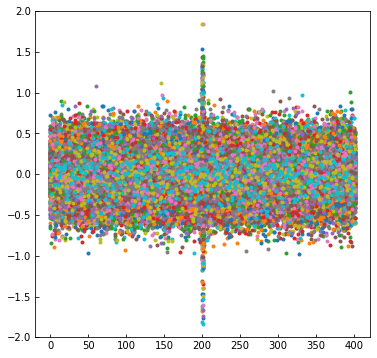

In [111]:
tap = 201
batch_size = 100
neuron = 300
epochs = 500
lr = 0.001
form = 'RZ16QAM'
PdBm = 1
Lmax = 2500

#signal_info_model = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
#signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}

model, mean, std = prepare_model(tap=tap, batch_size=batch_size, neuron=neuron, epochs=epochs, lr=lr, signal_info=signal_info_model, form=form, PdBm=PdBm, Lmax=Lmax)
weight = model.state_dict()['fc1.weight'].detach().numpy()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
for i in range(300): # [7, 25, 60, 160, 250]
    ax.plot(weight[i], '.')
ax.set_ylim((-2, 2))
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')

## 2.3 入力シンボル数(tap)依存性

In [ ]:
batch_size = 100
neuron = 300
epochs = 500
lr = 0.001
form = 'RZ16QAM'
PdBm = 1
Lmax = 2500

#signal_info_model = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
#signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}

#signal_info_input = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_input = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
#signal_info_input = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}



In [47]:
l_df = pd.read_csv(l_df_dir, index_col=0)
for i in range(len(l_df)):
    t = l_df.iloc[i]['image_number']
    t2 = ''
    for j in range(1, len(t), 3):
        if j == 1:
            t2 = t2 + t[j]
        else:
            t2 = t2 + ', ' + t[j]
        l_df['image_number'].loc[i] = t2
print(l_df['image_number'])
l_df.to_csv(l_df_dir)

0       0
1       0
2    0, 1
3    0, 1
Name: image_number, dtype: object
